In [1]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation2 import DataHandling 
from UNet_model import create_unet
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)



In [5]:
data_dir = '/homes/zshahpouri/DLP/ASC-PET-001'
directory = '/homes/zshahpouri/DLP/Practic/LOG'
output_dir = '/homes/zshahpouri/DLP/Practic/OUT'

In [6]:

train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]

# making  smaller input to save time for practing stage:
train_files, val_files =  data_dicts[:20], data_dicts[-1:]
# train_files, val_files =  data_dicts[-2:], data_dicts[-1:]
test_files = data_dicts[25:26]
set_determinism(seed=0)


In [7]:
roi_size = [168, 168, 320]

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00)),
        SpatialPadd(keys=["image", "target"], spatial_size=(200, 200, 350), mode='constant'),  # Pad to ensure minimum size
        # ScaleIntensityd(keys=["image", "target"], minv=0.0, maxv=1.0),
        CenterSpatialCropd(keys=["image", "target"], roi_size=roi_size),  # Crop to ensure exact size
        ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00)),
        SpatialPadd(keys=["image", "target"], spatial_size=(200, 200, 350), mode='constant'),  # Pad to ensure minimum size
        # ScaleIntensityd(keys=["image", "target"], minv=0.0, maxv=1.0),
        CenterSpatialCropd(keys=["image", "target"], roi_size=roi_size),  # Crop to ensure exact size
        ])

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=1)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=1)

test_ds = CacheDataset(data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=1)


Loading dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


In [8]:


loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

max_epochs = 10
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []


In [9]:
def find_last_saved_model(log_filepath):
    last_saved_model = None
    best_metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if "Saved" in line and ".pth" in line:
                parts = line.split(',')
                last_saved_model = parts[0].split()[1]  # Extract model filename
                best_metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
    return last_saved_model, best_metric, epoch


log_filename = 'log_2_6_8_38.txt'
log_filepath = directory + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_2_6_9_9.pth, Best Metric: 0.6757, Epoch: 10


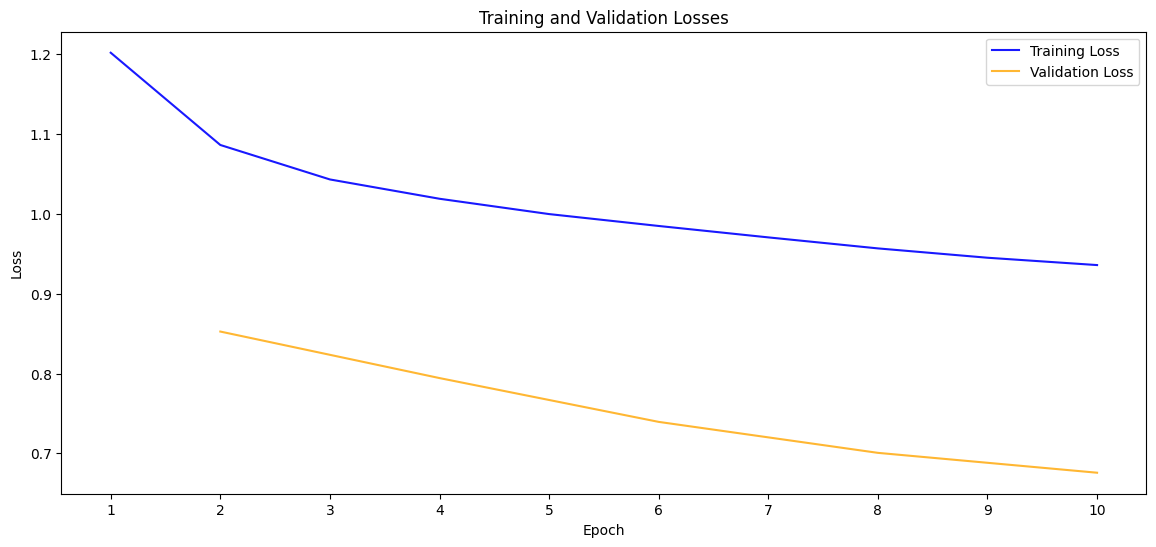

In [10]:

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses

# Replace this with the path to your actual log file

train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 1))  # Adjust the x-axis ticks if needed
plt.show()


In [14]:
import torch
from utils import find_model_info

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128),
    # default=[32, 64, 128, 256, 512, 32] MRI Recon
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)


def load_model(directory, model_filename):
    model_path = os.path.join(directory, model_filename)
    if os.path.exists(model_path):
        
        # Load the model onto the CPU
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        print(f"Model file {model_filename} is loaded successfully.")
    else:
        print(f"Model file {model_filename} not found.")


# Usage
# model_filename_to_find = bestmodel_filename
model_filename_to_find = 'model_2_6_8_50.pth'

load_model(directory, model_filename_to_find)

bestmodel_filename, metric, epoch = find_model_info(log_filepath, model_filename_to_find)
print(f"Model has been selected: {bestmodel_filename}, Metric: {metric}, Epoch: {epoch}")

Model file model_2_6_8_50.pth is loaded successfully.
Model has been selected: model_2_6_8_50.pth, Metric: 0.7943, Epoch: 4


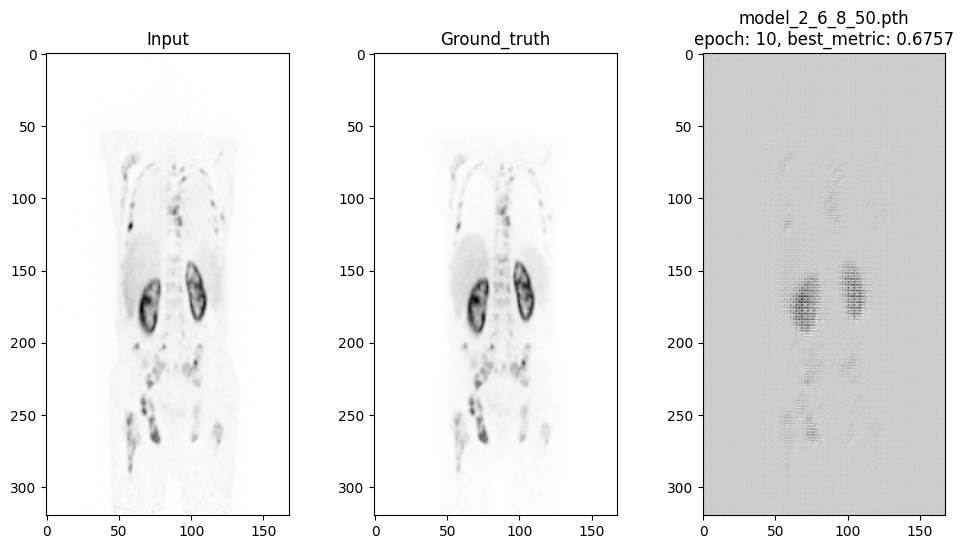

In [15]:
def visualize_results_whole(data, model, n, title):
    model.eval()
    with torch.no_grad():
        model_outputs = model(data["image"].to(device))

    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Ground_truth")
    target_slice = np.rot90(data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(model_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()

# Usage
with torch.no_grad():
    for i, data in enumerate(val_loader):
        n = 100
        visualize_results_whole(data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 2:
            break


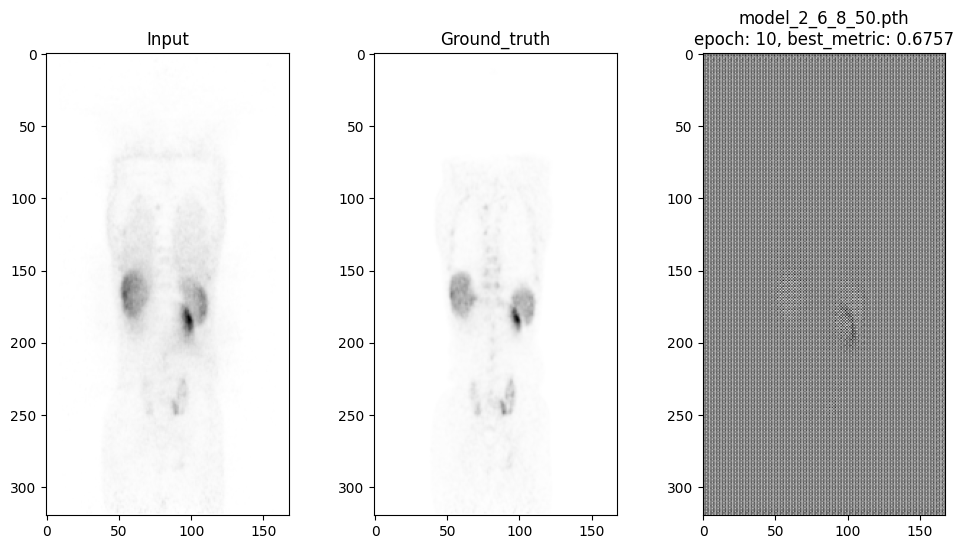

In [16]:
# Usage
with torch.no_grad():
    for i, data in enumerate(test_loader):
        n = 100
        visualize_results_whole(data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 2:
            break